# Ensemble Learning

This notebook consists of 3 parts:

0. Generating datasets.
1. Running Gradient Boosting Regression Trees (GBRT) on the the datasets.
2. Running AdaBoost on the the datasets.

In [1]:
import random
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)

### Part 0: Generating datasets 
    1) Generate at least two datasets with one binary label.
    2) Split the data to train and test sets
    3) Visualize the data (You can use dimensionality reduction if needed)

In [2]:
def create_dataset_1():
    """
    Returns dataset split to features (X), lables (y)
    The data has 3 features where feature 3 is redundant, it is highly correlated with feature 1
    The labels are balanced and dependent on features 1 and 2
    """
    n_samples = 1000
    n_features = 3
    n_informative = 2
    n_redundant = 1

    mean = np.zeros(n_features)
    cov = np.eye(n_features)

    X = np.random.multivariate_normal(mean=mean, cov=cov, size=n_samples)

    for i in range(n_informative):
        mean_i = np.random.uniform(low=-1.0, high=1.0)
        var_i = np.random.uniform(low=1.0, high=2.0)
        X[:, i] += np.random.normal(loc=mean_i, scale=var_i, size=n_samples)

    for i in range(n_redundant):
        X[:, n_informative + i] += np.random.normal(loc=-0.5, scale=0.5, size=n_samples)
        X[:, n_informative + i] = X[:, i]

    y = np.ones(n_samples)*(-1)
    y[X[:, 0]*np.random.normal(loc=1, scale=1, size=n_samples) + X[:, 1]*np.random.normal(loc=1, scale=1, size=n_samples) > 0] = 1
    
    return X, y

def create_dataset_2():
    """
    Returns dataset split to features (X), lables (y)
    The data has 2 features
    The labels are balanced
    """
    n_samples = 1000
    
    # Generate samples from a multivariate normal distribution around the origin
    cov_matrix = [[1,0],[0,1]]  # Covariance matrix for the normal distribution
    X = np.random.multivariate_normal([0, 0], cov_matrix, n_samples)
    
    # Calculate distances from the origin
    distances = np.linalg.norm(X, axis=1)
    
    # Assign labels based on distance from the origin
    inner_negative_radius = 1
    outer_negative_radius = 2
    y = np.where(((distances <= inner_negative_radius) | (distances >= outer_negative_radius)), -1, 1)
    
    return X, y

In [3]:
X_1, y_1 = create_dataset_1()
X_2, y_2 = create_dataset_2()
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

In [4]:
print("Short EDA of datasets \n")
print("Dataset 1:")
print('Number of training samples:', len(X_1_train))
print('Number of testing samples:', len(X_1_test))
print(f'Class balance: C0={np.sum(y_1==-1)}, C1={np.sum(y_1==1)}')
print("--------------------------")
print("Dataset 2:")
print('Number of training samples:', len(X_2_train))
print('Number of testing samples:', len(X_2_test))
print(f'Class balance: C0={np.sum(y_2==-1)}, C1={np.sum(y_2==1)}')

Short EDA of datasets 

Dataset 1:
Number of training samples: 800
Number of testing samples: 200
Class balance: C0=444, C1=556
--------------------------
Dataset 2:
Number of training samples: 800
Number of testing samples: 200
Class balance: C0=527, C1=473


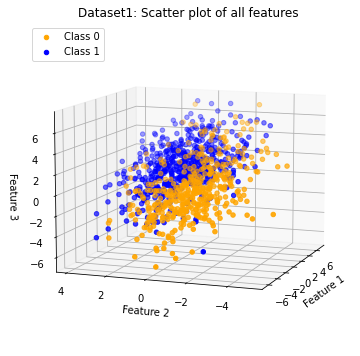

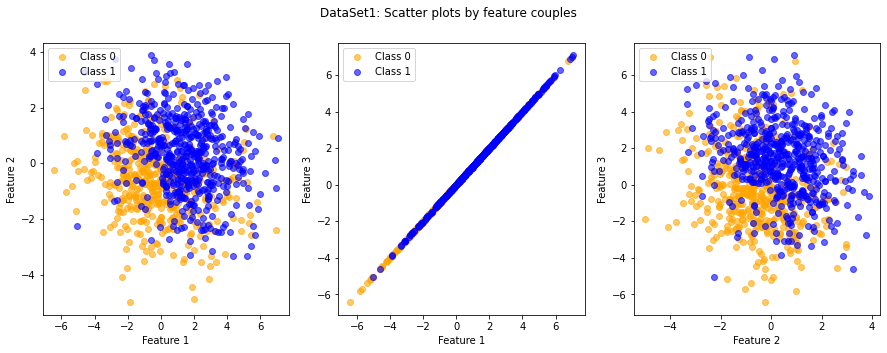

In [5]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_1[y_1==-1, 0], X_1[y_1==-1, 1], X_1[y_1==-1, 2], c='orange', label='Class 0')
ax.scatter(X_1[y_1==1, 0], X_1[y_1==1, 1], X_1[y_1==1, 2], c='b', label='Class 1')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.azim = 200
ax.elev = 10
plt.title("Dataset1: Scatter plot of all features ")
plt.legend(loc="upper left")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('DataSet1: Scatter plots by feature couples')
axs[0].scatter(X_1[y_1==-1, 0], X_1[y_1==-1, 1], c='orange', label='Class 0', alpha=0.6)
axs[0].scatter(X_1[y_1==1, 0], X_1[y_1==1, 1], c='b', label='Class 1', alpha=0.6)
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')
axs[0].legend(loc = "upper left")

axs[1].scatter(X_1[y_1==-1, 0], X_1[y_1==-1, 2], c='orange', label='Class 0', alpha=0.6)
axs[1].scatter(X_1[y_1==1, 0], X_1[y_1==1, 2], c='b', label='Class 1', alpha=0.6)
axs[1].set_xlabel('Feature 1')
axs[1].set_ylabel('Feature 3')
axs[1].legend(loc = "upper left")

axs[2].scatter(X_1[y_1==-1, 1], X_1[y_1==-1, 2], c='orange', label='Class 0', alpha=0.6)
axs[2].scatter(X_1[y_1==1, 1], X_1[y_1==1, 2], c='b', label='Class 1', alpha=0.6)
axs[2].set_xlabel('Feature 2')
axs[2].set_ylabel('Feature 3')
axs[2].legend(loc = "upper left")

plt.show()

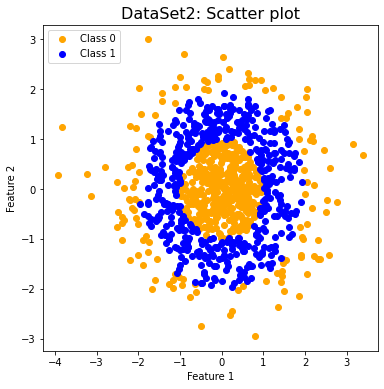

In [6]:
# Visualization of dataset2
plt.figure(figsize=(6, 6))
plt.scatter(X_2[y_2==-1, 0], X_2[y_2==-1, 1], c='orange', label='Class 0')
plt.scatter(X_2[y_2==1, 0], X_2[y_2==1, 1], c='b', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DataSet2: Scatter plot', fontsize=16)
plt.legend(loc = "upper left")
plt.show()

### Part 1: Gradient Boosting Regression Trees (GBRT)
    4) Implement GBRT
        a) Loss function
        b) Residuals calculation
        c) Weak regression tree
        d) Boosting step

In [7]:
class GradientBoostingRegressionTree(BaseEstimator):
    def __init__(self, n_estimators=100, alpha=0.01, max_depth=3):
        self.all_trees = []
        self.alpha = alpha
        self.n_estimators = n_estimators
        self.max_depth = max_depth

    def fit(self, X, y):
        assert np.all(
            (y == -1) | (y == 1)
        ), "the implementation  assuming binary functions, using (-1,1) labels"
        self.all_loss = []

        first_tree = DecisionTreeRegressor(max_depth=self.max_depth).fit(X, y)
        self.all_trees.append(first_tree)

        curr_H = np.zeros(y.shape)

        for i in range(self.n_estimators):
            curr_H += self.alpha * self.all_trees[i].predict(X)
            residual = y - curr_H  # Residuals calculation

            new_tree = DecisionTreeRegressor(max_depth=self.max_depth)
            new_tree.fit(X, residual)
            predicted_y = new_tree.predict(X)
            curr_loss = mean_squared_error(residual, predicted_y)
            self.all_loss.append(curr_loss)
            self.all_trees.append(new_tree)

        return self

    def predict(self, X):
        curr_H = np.zeros((X.shape[0],))
        for curr_tree in self.all_trees:
            curr_H += self.alpha * curr_tree.predict(X)

        return np.where((curr_H >= 0), 1, -1)

    def score(self, X, y):
        predicted = self.predict(X)
        return sum(predicted == y) / len(y)

    5) Demonstrate your GBRT model on the datasets you generated

train & Evaluate on dataset 1
Gradient Boosting Regression Trees Train Accuracy: 0.8742857142857143
Gradient Boosting Regression Trees Test Accuracy: 0.7566666666666667


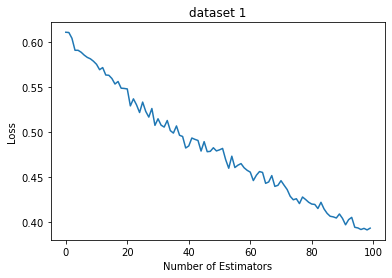

-------------------------------

train & Evaluate on dataset 2
Gradient Boosting Regression Trees Train Accuracy: 0.9771428571428571
Gradient Boosting Regression Trees Test Accuracy: 0.92


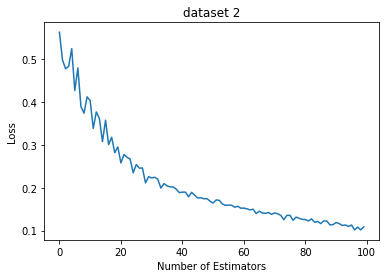

-------------------------------



In [8]:
for dataset_name, curr_dataset in (
    ("dataset 1", (X_1, y_1)),
    ("dataset 2", (X_2, y_2)),
):
    _, ax = plt.subplots(1)
    
    plt.xlabel('Number of Estimators')
    plt.ylabel('Loss')
    plt.title(dataset_name)
    
    print(f"train & Evaluate on {dataset_name}")
    curr_x, curr_y = curr_dataset
    X_train, X_test, y_train, y_test = train_test_split(
        curr_x, curr_y, test_size=0.3, random_state=42
    )

    model = GradientBoostingRegressionTree(n_estimators=100, alpha=0.1, max_depth=3)
    model.fit(X_train, y_train)
    gbrt_train_acc = model.score(X_train, y_train)
    gbrt_test_acc = model.score(X_test, y_test)
    print(f"Gradient Boosting Regression Trees Train Accuracy: {gbrt_train_acc}")
    print(f"Gradient Boosting Regression Trees Test Accuracy: {gbrt_test_acc}")
    
    ax.plot(pd.DataFrame(model.all_loss))
    plt.show()
    
    print("-------------------------------\n")

    6) Design and perform experiments to test the performance of your model. Present and discuss
       the results of the experiments.

In [9]:
experiment_setting = [{'max_depth': x} for x in range(1,7)]
experiment_setting += [{'n_estimators': x} for x in (1, 10,30, 50, 100, 200, 300, 500, 600)]
experiment_setting += [{'alpha': x} for x in (0.1, 0.01, 0.001)]

experiment_setting += [{'max_depth':6, 'n_estimators': 1000,  'alpha': 0.00001}]
experiment_setting += [{'max_depth':6, 'n_estimators': 1}]
experiment_setting += [{'max_depth':1, 'alpha': 0.1}]
experiment_setting += [{'max_depth':1, 'alpha': 0.01, 'n_estimators': 500 }]
experiment_setting += [{'max_depth':2, 'alpha': 0.1, 'n_estimators': x } for x in (1, 100, 200, 500)]

X_train, X_test, y_train, y_test = train_test_split(
        X_2, y_2, test_size=0.3, random_state=42
    )

df_experiments_results = pd.DataFrame()

model_settings_to_loss = {}

for experiment_setting in tqdm.tqdm(experiment_setting):
    model = GradientBoostingRegressionTree(**experiment_setting)
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    curr_experiment = {attr: getattr(model, attr) for attr in ['max_depth', 'n_estimators', 'alpha']
                         }
    
    curr_experiment.update({'train_acc' : train_acc, 'test_acc': test_acc})
    
    model_settings_to_loss[str(experiment_setting)] = model.all_loss.copy()
    
    df_experiments_results = df_experiments_results.append(curr_experiment,ignore_index=True)


100%|██████████| 26/26 [00:05<00:00,  4.59it/s]


**Data for the report**

In [10]:
df_experiments_results.sort_values('test_acc', ascending=True)

,alpha,max_depth,n_estimators,test_acc,train_acc
0,0.01000,1.0,100.0,0.650000,0.711429
22,0.10000,2.0,1.0,0.663333,0.740000
17,0.00100,3.0,100.0,0.743333,0.824286
7,0.01000,3.0,10.0,0.743333,0.824286
6,0.01000,3.0,1.0,0.743333,0.824286
8,0.01000,3.0,30.0,0.743333,0.825714
1,0.01000,2.0,100.0,0.763333,0.852857
21,0.01000,1.0,500.0,0.763333,0.834286
9,0.01000,3.0,50.0,0.816667,0.911429
20,0.10000,1.0,100.0,0.836667,0.922857


In [11]:
df_experiments_results.test_acc.describe().to_frame()

,test_acc
count,26.000000
mean,0.835256
std,0.081405
min,0.650000
25%,0.763333
50%,0.856667
75%,0.905833
max,0.920000


In [12]:
df_experiments_results[df_experiments_results['max_depth']==2].sort_values('test_acc', ascending=True)

,alpha,max_depth,n_estimators,test_acc,train_acc
22,0.10,2.0,1.0,0.663333,0.740000
1,0.01,2.0,100.0,0.763333,0.852857
23,0.10,2.0,100.0,0.893333,0.954286
24,0.10,2.0,200.0,0.896667,0.961429
25,0.10,2.0,500.0,0.903333,0.987143


### Part 2: AdaBoost
    7) Implement AdaBoost
        a) Weights (w_i)
        b) Decision stump
        c) Weighted classification error (eps)
        d) Step size (alpha)
        e) Boosting step
        f) Updating weights
    8) Demonstrate your AdaBoost model on the datasets you generated
    9) Design and perform experiments to test the performance of your model. Present and discuss
       the results of the experiments.

In [13]:
# Implementing AdaBoost

class AdaBoost:
    def __init__(self, n_estimators=100):
        self.n_estimators = n_estimators
        self.estimators_ = []
        self.estimator_weights_ = []

    def fit(self, X, y):
        w = np.full(X.shape[0], 1 / X.shape[0])   # Initialize weights
        for m in range(self.n_estimators):
            
            # Sample from the data with replacement
            sample_indices = np.random.choice(X.shape[0], size=X.shape[0],p=w, replace=True)
            X_sampled = X[sample_indices]
            y_sampled = y[sample_indices]
            
            # Fit a decision stump
            clf = DecisionTreeClassifier(max_depth=1)
            clf.fit(X_sampled, y_sampled)
            
            # Calculate weighted classification error
            pred = clf.predict(X)
            correct = [int(pred[i] != y[i]) for i in range(len(y))]
            error = np.dot(w, correct)
            error = max(error, 1e-15)       # add a small constant to avoid division by zero
            error = min(error, 1 - 1e-15)   # subtract a small constant to avoid division by zero
            
            # Calculate estimator weight size
            alpha_m = 0.5 * (np.log((1 - error) / error) / np.log(np.e))
            
            # Update weights
            w *= np.exp(-alpha_m * pred * y)       
            w /= 2*np.sqrt(error*(1-error))
            
            # Save the current estimator and its weight
            self.estimators_.append(clf)
            self.estimator_weights_.append(alpha_m)

    def predict(self, X):
        # Make predictions using the weighted majority vote of the ensemble
        y_pred = np.zeros(X.shape[0])
        for alpha_m, clf in zip(self.estimator_weights_, self.estimators_):
            y_pred += alpha_m * clf.predict(X)
        return np.where((y_pred>0), 1, -1)
    
    def calc_acc(self, pred, y):
        correct = sum([int(pred[i] == y[i]) for i in range(len(y))])
        return correct/len(y)

In [14]:
# Demonstrating our AdaBoost model on the datasets we generated
# Performing experiments to test the performance of our model over number of estimators hyperparameter 

adaboost_train_acc_1 = []
adaboost_test_acc_1 = []
adaboost_train_acc_2 = []
adaboost_test_acc_2 = []
n_estimators = range(0,150)

for i in n_estimators:
    adaboost_clf_1 = AdaBoost(i)
    adaboost_clf_1.fit(X_1_train, y_1_train)
    adaboost_train_acc_1.append(adaboost_clf_1.calc_acc(adaboost_clf_1.predict(X_1_train), y_1_train))
    adaboost_test_acc_1.append(adaboost_clf_1.calc_acc(adaboost_clf_1.predict(X_1_test),y_1_test))
    
    adaboost_clf_2 = AdaBoost(i)
    adaboost_clf_2.fit(X_2_train, y_2_train)
    adaboost_train_acc_2.append(adaboost_clf_2.calc_acc(adaboost_clf_2.predict(X_2_train), y_2_train))
    adaboost_test_acc_2.append(adaboost_clf_2.calc_acc(adaboost_clf_2.predict(X_2_test),y_2_test))

In [15]:
best_acc_1 = np.max(adaboost_test_acc_1)
best_n_est_1 = np.argmax(adaboost_test_acc_1)
best_acc_2 = np.max(adaboost_test_acc_2)
best_n_est_2 = np.argmax(adaboost_test_acc_2)

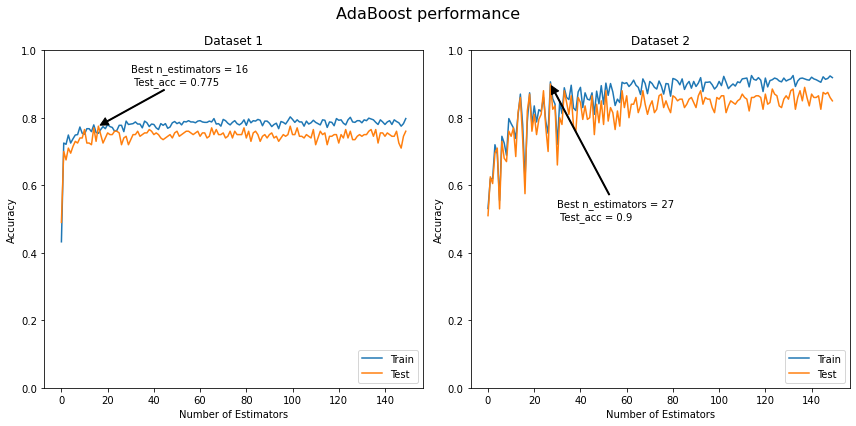

Dataset1:
AdaBoost best Test Accuracy: 0.775
-------------------------------
Dataset2:
AdaBoost best Test Accuracy: 0.9


In [16]:
plt.figure(figsize=(12, 6))

plt.suptitle('AdaBoost performance', fontsize=16)

# Plot for dataset 1
plt.subplot(1, 2, 1)
plt.plot(n_estimators, adaboost_train_acc_1, label='Train')
plt.plot(n_estimators, adaboost_test_acc_1, label='Test')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Dataset 1')
plt.legend(loc = "lower right")
plt.ylim(0, 1)
plt.annotate(f'Best n_estimators = {best_n_est_1} \n Test_acc = {best_acc_1}',(best_n_est_1, best_acc_1), xytext=(30,0.9),
   color='black', size='medium',
   arrowprops=dict(
      arrowstyle='simple,tail_width=0.1,head_width=0.8,head_length=0.8',
      facecolor='black'))

# Plot for dataset 2
plt.subplot(1, 2, 2)
plt.plot(n_estimators, adaboost_train_acc_2, label='Train')
plt.plot(n_estimators, adaboost_test_acc_2, label='Test')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Dataset 2')
plt.legend(loc = "lower right")
plt.ylim(0, 1)
plt.annotate(f'Best n_estimators = {best_n_est_2} \n Test_acc = {best_acc_2}',(best_n_est_2, best_acc_2), xytext=(30,0.5),
   color='black', size='medium',
   arrowprops=dict(
      arrowstyle='simple,tail_width=0.1,head_width=0.8,head_length=0.8',
      facecolor='black'))

plt.tight_layout()
plt.show()

print(f"Dataset1:")
print(f"AdaBoost best Test Accuracy: {best_acc_1}")
print("-------------------------------")
print(f"Dataset2:")
print(f"AdaBoost best Test Accuracy: {best_acc_2}")

The AdaBoost classifier was applied to both datasets and yielded results that were in line with our expectations. Despite the use of weak classifiers (single depth decision stumps), the performance exhibited considerable effectiveness.  It is worth noting that both datasets are characterized by noise and lack linear separability in their original feature space, posing challenges for linear classifiers. <br>
For Dataset 1, the labels are solely dependent on features 1 and 2. By applying two simple constraints, a test accuracy of 0.685 was achieved: 
\begin{cases}
1 & \forall i \in [0,\text{Samplespace size}], \text{ if } X[i,0] > 0 \text{ or } X[i,1] > 0 \\
-1 & \text{otherwise}
\end{cases}
Based on our expectations, an increase in the number of estimators beyond 2 does not significantly improve performance. This observation is visually evident in the provided plot, where the accuracy plateaus after reaching a number of estimators greater than 2. The best accuracy falling in the range of $[2,150]$ estimators is subject to stochastic noise.<br>

For Dataset 2, the labels exhibit a more complex dependence on both features. As the number of estimators increases, performance improves up to a threshold of approximately 30. Beyond this threshold, the improvement in performance becomes marginal. This indicates that indiscriminately increasing the number of estimators does not always lead to a significant accuracy gain.

### Comparing test results to scikit-learn for sanity check

In [17]:
# Simple classifier for dataset1
pred = [1 if x[0]>0 or x[1]>0 else -1 for x in X_1_test]
acc = np.sum(pred == y_1_test) / len(y_1_test)
print(acc)

0.685


In [18]:
from sklearn.ensemble import GradientBoostingClassifier
reg = GradientBoostingClassifier(random_state=0)
reg.fit(X_1_train, y_1_train)
reg.score(X_1_test, y_1_test)

0.765

In [19]:
reg = GradientBoostingClassifier(random_state=0)
reg.fit(X_2_train, y_2_train)
reg.score(X_2_test, y_2_test)

0.935

In [20]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_1_train, y_1_train)
clf.score(X_1_test, y_1_test)

0.735

In [21]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_2_train, y_2_train)
clf.score(X_2_test, y_2_test)

0.86